# Question 1 Part A Mountain Car

In [1]:
import gym
import torch.nn

env = gym.make("MountainCar-v0")
observation, info = env.reset(seed=42)
print("Action space:", env.action_space)
print("State space:", env.observation_space)
t = 0
while 1:
    t += 1
    action = env.action_space.sample()  # User-defined policy function
    observation, reward, terminated, truncated, info = env.step(action)
    print(f"Reward at step {t}:", reward)
    if terminated or truncated:
        break
env.close()

Action space: Discrete(3)
State space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Reward at step 1: -1.0
Reward at step 2: -1.0
Reward at step 3: -1.0
Reward at step 4: -1.0
Reward at step 5: -1.0
Reward at step 6: -1.0
Reward at step 7: -1.0
Reward at step 8: -1.0
Reward at step 9: -1.0
Reward at step 10: -1.0
Reward at step 11: -1.0
Reward at step 12: -1.0
Reward at step 13: -1.0
Reward at step 14: -1.0
Reward at step 15: -1.0
Reward at step 16: -1.0
Reward at step 17: -1.0
Reward at step 18: -1.0
Reward at step 19: -1.0
Reward at step 20: -1.0
Reward at step 21: -1.0
Reward at step 22: -1.0
Reward at step 23: -1.0
Reward at step 24: -1.0
Reward at step 25: -1.0
Reward at step 26: -1.0
Reward at step 27: -1.0
Reward at step 28: -1.0
Reward at step 29: -1.0
Reward at step 30: -1.0
Reward at step 31: -1.0
Reward at step 32: -1.0
Reward at step 33: -1.0
Reward at step 34: -1.0
Reward at step 35: -1.0
Reward at step 36: -1.0
Reward at step 37: -1.0
Reward at step 38: -1.0
Reward at s

/home/dishank/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


I observed that the environment consists of a state space as a 2 vector which has position and velocity. The reward is -1 for every step until we reach the goal state. The game is truncated at 200 steps. We can take the actions: left(0), right(2) or no action(1).

In [2]:
import torch.nn as nn
from torch.nn.functional import relu

class MountainCar(nn.Module):
    def __init__(self):
        super(MountainCar, self).__init__()
        self.input = nn.Linear(2, 64)
        self.hid1 = nn.Linear(64, 128)
        self.hid2 = nn.Linear(128, 256)
        self.out = nn.Linear(256, 3)

    def forward(self, x):
        return self.out(relu(self.hid2(relu(self.hid1(relu(self.input(x)))))))

In [3]:
from collections import deque
import torch
import numpy as np
import random
import torch.optim as optim

torch.manual_seed(422)
random.seed(422)

device = "cpu"
class DQN:
    def __init__(self, model, environment, buff):
        self.buffer = deque(maxlen=buff)
        self.gamma = 0.99
        self.epsilon = 1

        self.model = model()
        self.model = self.model.to(device)
        self.target = model()
        self.target = self.target.to(device)
        self.target.load_state_dict(self.model.state_dict())

        self.env_ = gym.make(environment)
        self.opt = optim.Adam(params=self.model.parameters(), lr=0.001)

    def policy(self, state_):
        state_ = torch.tensor(state_).to(device)
        model_output = self.model(state_)
        best_action = np.argmax(model_output.detach().cpu().numpy())
        wts = [self.epsilon/3]*3
        wts[best_action] += 1-self.epsilon
        taken = random.choices([0, 1, 2], wts, k=1)[0]
        return taken

    def game(self):
        obs_, _ = self.env_.reset()
        total_reward = 0
        while 1:
            action_ = self.policy(obs_)  # User-defined policy function
            new_obs, reward_, terminated_, truncated_, _ = self.env_.step(action_)
            total_reward += reward_
            if obs_[1] * (action_ - 1) > 0:
                reward_ = 1.0
            else:
                reward_ = -1.0
            if terminated_ or truncated_:
                reward_ = 100

            self.buffer.append([obs_, action_, reward_, new_obs, terminated_ or truncated_])
            # print(self.buffer[-1])

            if len(self.buffer) > 100:
                samples = random.sample(self.buffer, 32)
                self.opt.zero_grad()
                x = torch.tensor(np.array([ex[0] for ex in samples]))
                y_target = torch.tensor(np.array([ex[2] for ex in samples]))
                next_state = torch.tensor(np.array([ex[3] for ex in samples])).to(device)
                x, y_target = x.to(device), y_target.to(device)
                tmp = self.target(next_state).detach()
                actions = torch.argmax(tmp, 1)
                y_pred = self.model(x)
                to_be_or_not_to_be = torch.tensor(np.array([ex[4] for ex in samples])).to(device)
                y_target += self.gamma * tmp[torch.arange(len(y_target)), actions] * (~to_be_or_not_to_be)
                y_pred = y_pred[torch.arange(len(y_pred)), actions]
                loss = torch.nn.functional.mse_loss(y_pred.float(), y_target.float())
                loss.backward()
                self.opt.step()


            obs_ = new_obs
            if terminated_ or truncated_:
                break
        return total_reward

    def train(self):
        final = []
        for _ in range(10):
            r = self.game()
            final.append(r)
            self.epsilon *= 0.995
            self.epsilon = max(self.epsilon, 0.01)
        self.target.load_state_dict(self.model.state_dict())
        return final

    def actions(self):
        obs_, _ = self.env_.reset()
        final = []
        while 1:
            action_ = self.policy(obs_)  # User-defined policy function
            new_obs, reward_, terminated_, truncated_, _ = self.env_.step(action_)
            final.append(obs_+[action])
            if terminated_ or truncated_:
                break

        return final


# Question 1 Part B Mountain Car

 15%|█▍        | 37/250 [02:14<12:55,  3.64s/it]


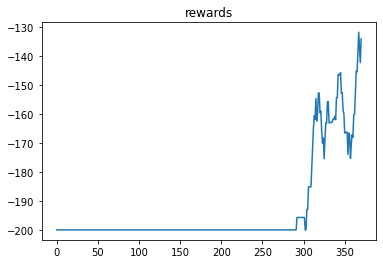

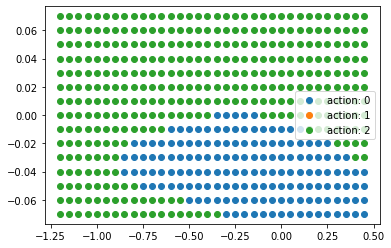

In [4]:
from tqdm import tqdm
import matplotlib.pyplot as plt

a = DQN(MountainCar, "MountainCar-v0", 2500)

rewards = []
for v in tqdm(range(250)):
    rewards.extend(a.train())
    if np.mean(rewards[-10:]) > -140:
        break

final2 = []
for i in range(len(rewards)-10+1):
    final2.append(sum(rewards[i:i+10])/10)

plt.plot(final2)
plt.title("rewards")
plt.show()

action_position_velocity = a.actions()
fig = plt.figure()
ax = fig.subplots()


data_x = [[] for _ in range(3)]
data_y = [[] for _ in range(3)]


x_ = torch.arange(-1.2, 0.5, 0.05)
y_ = torch.arange(-0.07, 0.07, 0.01)
for i in x_:
    for j in y_:
        state = torch.tensor((i, j))
        action = torch.argmax(a.model.forward(state)).detach().__int__()
        data_x[action].append(i)
        data_y[action].append(j)
for i in range(3):
    ax.scatter(data_x[i], data_y[i], label=f'action: {i}')
ax.legend()
plt.show()

# Question 1 Part C Mountain Car

100%|██████████| 250/250 [16:53<00:00,  4.05s/it]


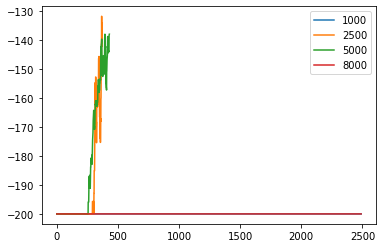

In [5]:
a = DQN(MountainCar, "MountainCar-v0", 1000)

rewards = []
for v in tqdm(range(250)):
    rewards.extend(a.train())
    if np.mean(rewards[-10:]) > -140:
        break

final1 = []
for i in range(len(rewards)-10+1):
    final1.append(sum(rewards[i:i+10])/10)


a = DQN(MountainCar, "MountainCar-v0", 5000)

rewards = []
for v in tqdm(range(250)):
    rewards.extend(a.train())
    if np.mean(rewards[-10:]) > -140:
        break

final3 = []
for i in range(len(rewards)-10+1):
    final3.append(sum(rewards[i:i+10])/10)


a = DQN(MountainCar, "MountainCar-v0", 8000)

rewards = []
for v in tqdm(range(250)):
    rewards.extend(a.train())
    if np.mean(rewards[-10:]) > -140:
        break

final4 = []
for i in range(len(rewards)-10+1):
    final4.append(sum(rewards[i:i+10])/10)

plt.plot(final1, label="1000")
plt.plot(final2, label="2500")
plt.plot(final3, label="5000")
plt.plot(final4, label="8000")
plt.legend()
plt.show()

# Question 1 Part A Pong

In [6]:
env = gym.make("Pong-v0")
observation, info = env.reset(seed=42)
print("Action space:", env.action_space)
print("State space:", env.observation_space)
t = 0
while 1:
    t += 1
    action = env.action_space.sample()  # User-defined policy function
    observation, reward, terminated, truncated, info = env.step(action)
    print(f"Reward at step {t}:", reward)
    if terminated or truncated:
        break
env.close()

/home/dishank/.local/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Pong-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]


Action space: Discrete(6)
State space: Box(0, 255, (210, 160, 3), uint8)
Reward at step 1: 0.0
Reward at step 2: 0.0
Reward at step 3: 0.0
Reward at step 4: 0.0
Reward at step 5: 0.0
Reward at step 6: 0.0
Reward at step 7: 0.0
Reward at step 8: 0.0
Reward at step 9: 0.0
Reward at step 10: 0.0
Reward at step 11: 0.0
Reward at step 12: 0.0
Reward at step 13: 0.0
Reward at step 14: 0.0
Reward at step 15: 0.0
Reward at step 16: 0.0
Reward at step 17: 0.0
Reward at step 18: 0.0
Reward at step 19: 0.0
Reward at step 20: 0.0
Reward at step 21: 0.0
Reward at step 22: 0.0
Reward at step 23: 0.0
Reward at step 24: 0.0
Reward at step 25: 0.0
Reward at step 26: 0.0
Reward at step 27: 0.0
Reward at step 28: 0.0
Reward at step 29: 0.0
Reward at step 30: 0.0
Reward at step 31: 0.0
Reward at step 32: 0.0
Reward at step 33: 0.0
Reward at step 34: 0.0
Reward at step 35: 0.0
Reward at step 36: 0.0
Reward at step 37: 0.0
Reward at step 38: 0.0
Reward at step 39: 0.0
Reward at step 40: 0.0
Reward at step 4

I observed that the environment consists of a state space as an image of shape 210x160x3 which is an RGB image. The reward is 1 for time the opponent misses and -1 for everytime we miss. The reward is 0 otherwise. The actions we can take are to go up, to go down or to take no action.

# Question 2 Part A Cartpole

In [7]:
env = gym.make("CartPole-v0")
observation, info = env.reset(seed=42)
print("Action space:", env.action_space)
print("State space:", env.observation_space)
t = 0
while 1:
    t += 1
    action = env.action_space.sample()  # User-defined policy function
    observation, reward, terminated, truncated, info = env.step(action)
    print(f"Reward at step {t}:", reward)
    if terminated or truncated:
        break
env.close()

Action space: Discrete(2)
State space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Reward at step 1: 1.0
Reward at step 2: 1.0
Reward at step 3: 1.0
Reward at step 4: 1.0
Reward at step 5: 1.0
Reward at step 6: 1.0
Reward at step 7: 1.0
Reward at step 8: 1.0
Reward at step 9: 1.0
Reward at step 10: 1.0
Reward at step 11: 1.0
Reward at step 12: 1.0
Reward at step 13: 1.0
Reward at step 14: 1.0
Reward at step 15: 1.0
Reward at step 16: 1.0
Reward at step 17: 1.0
Reward at step 18: 1.0
Reward at step 19: 1.0
Reward at step 20: 1.0


/home/dishank/.local/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


I observed that the environment consists of a state space as a 4 vector. The reward is 1 for time the game is ongoing.

# Question 2 Part A LunarLander

In [8]:
env = gym.make("LunarLander-v2")
observation, info = env.reset(seed=42)
print("Action space:", env.action_space)
print("State space:", env.observation_space)
t = 0
while 1:
    t += 1
    action = env.action_space.sample()  # User-defined policy function
    observation, reward, terminated, truncated, info = env.step(action)
    print(f"Reward at step {t}:", reward)
    if terminated or truncated:
        break
env.close()

Action space: Discrete(4)
State space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Reward at step 1: -2.497033478022092
Reward at step 2: 1.1733043253677522
Reward at step 3: 1.1760863985095114
Reward at step 4: 0.10405853636243137
Reward at step 5: 0.05904046917129449
Reward at step 6: -2.1025746594950645
Reward at step 7: -0.3388957993509496
Reward at step 8: 0.3086936815717536
Reward at step 9: 1.2398406000315572
Reward at step 10: 1.5133318035323395
Reward at step 11: -1.5816470851144573
Reward at step 12: 0.5609470211577445
Reward at step 13: 1.270237332605974
Reward at step 14: 0.4220091100253569
Reward at step 15: 1.1209752292540724
Reward at step 16: -0.9465092271497315
Reward at step 17: -1.3569924659730919
Reward at step 18: -0.7918073542406603
Reward at step 19: -0.007175326300425694
Reward at step 20: -2.4487068077596335
Reward at step 21:

I observed that the environment consists of a state space as a 8 vector. The reward is variable for each step depending on the state but the final reward is -100 if the Lander does not land correctly.

In [9]:
import torch.nn as nn
from torch.nn.functional import relu, softmax

class CartPole(nn.Module):
    def __init__(self):
        super(CartPole, self).__init__()
        self.input = nn.Linear(4, 64)
        self.hid1 = nn.Linear(64, 128)
        self.hid2 = nn.Linear(128, 256)
        self.out = nn.Linear(256, 2)

    def forward(self, x):
        return softmax(self.out(relu(self.hid2(relu(self.hid1(relu(self.input(x))))))), dim=0)

In [10]:
import torch.nn as nn
from torch.nn.functional import relu, softmax

class LunarLander(nn.Module):
    def __init__(self):
        super(LunarLander, self).__init__()
        self.input = nn.Linear(8, 64)
        self.hid1 = nn.Linear(64, 128)
        self.hid2 = nn.Linear(128, 256)
        self.out = nn.Linear(256, 2)

    def forward(self, x):
        return softmax(self.out(relu(self.hid2(relu(self.hid1(relu(self.input(x))))))), dim=0)

In [11]:
from collections import deque
import torch
import numpy as np
import random
import torch.optim as optim

torch.manual_seed(422)
random.seed(422)

device = "cpu"
class PolicyGradients:
    def __init__(self, model, environment, K):
        self.model = model()
        self.model = self.model.to(device)
        self.gamma = 0.99
        self.K = K

        self.env_ = gym.make(environment)
        self.opt = optim.Adam(params=self.model.parameters(), lr=0.001)

    def policy(self, state_):
        state_ = torch.tensor(state_).to(device)
        model_output = self.model(state_)
        probs = model_output.detach().cpu().numpy()
        probs = list(probs)
        action_ = random.choices([0, 1], probs, k=1)[0]
        return action_

    def game(self):
        obs_, _ = self.env_.reset()
        trajectory = [obs_]
        total_reward = 0
        while 1:
            action_ = self.policy(obs_)  # User-defined policy function
            new_obs, reward_, terminated_, truncated_, _ = self.env_.step(action_)
            total_reward += reward_
            trajectory.extend([action_, reward_, new_obs])

            obs_ = new_obs
            if terminated_ or truncated_:
                break
        return total_reward, trajectory

    def train(self):
        samples = []
        rewards_ = []
        for _ in range(self.K):
            r_, t_ = self.game()
            samples.append(t_)
            rewards_.append(r_)
        loss = 0
        for t_ in samples:
            g = 0
            loss_t = 0
            for time in range(len(t_)//3):
                loss_t += torch.log(self.model(torch.tensor(t_[3*time]))[t_[3*time+1]])
                g += (self.gamma ** time) * t_[3 * time + 2]
            loss += g*loss_t
        loss = -loss/self.K
        loss.backward()
        self.opt.step()
        return np.mean(rewards_)

    def train_reward_to_go(self):
        samples = []
        rewards_ = []
        for _ in range(self.K):
            r_, t_ = self.game()
            samples.append(t_)
            rewards_.append(r_)
        loss = 0
        for t_ in samples:
            loss_t = 0
            for time in range(len(t_)//3):
                reward_to_go = 0
                for u in range(len(t_)//3-time):
                    reward_to_go += (self.gamma ** u) * t_[3 * (time + u) + 2]
                loss_t += torch.log(self.model(torch.tensor(t_[3*time]))[t_[3*time+1]]) * reward_to_go
            loss += loss_t
        loss = -loss/self.K
        loss.backward()
        self.opt.step()
        return np.mean(rewards_)

    # time dependent baseline
    def train_advantage_normalisation(self):
        samples = []
        rewards_ = []
        for _ in range(self.K):
            r_, t_ = self.game()
            samples.append(t_)
            rewards_.append(r_)
        lens = [len(t_)//3 for t_ in samples]
        baselines = []
        for time in range(max(lens)):
            baseline = 0
            nums = 0
            for t_ in samples:
                if len(t_) // 3 > time:
                    nums += 1
                    for u in range(len(t_)//3-time):
                        baseline += (self.gamma ** u) * t_[3 * (time + u) + 2]
            baseline /= nums
            baselines.append(baseline)
        loss = 0
        for t_ in samples:
            loss_t = 0
            for time in range(len(t_)//3):
                reward_to_go = 0
                for u in range(len(t_)//3-time):
                    reward_to_go += (self.gamma ** u) * t_[3 * (time + u) + 2]
                loss_t += torch.log(self.model(torch.tensor(t_[3*time]))[t_[3*time+1]]) * (reward_to_go - baselines[time])
            loss += loss_t
        loss = -loss/self.K
        loss.backward()
        self.opt.step()
        return np.mean(rewards_)

# Question 2 Part B CartPole

100%|██████████| 500/500 [02:58<00:00,  2.80it/s]


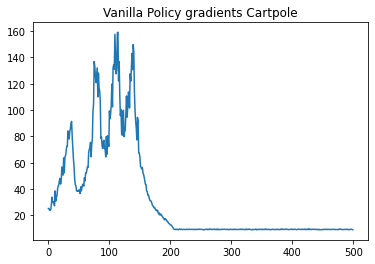

In [12]:
a = PolicyGradients(CartPole, "CartPole-v0", 32)

rewards = []
for v in tqdm(range(500)):
    rewards.append(a.train())
    if np.mean(rewards[-3:]) > 160:
        break

plt.plot(rewards)
plt.title("Vanilla Policy gradients Cartpole")
plt.show()

  8%|▊         | 42/500 [00:28<05:13,  1.46it/s]


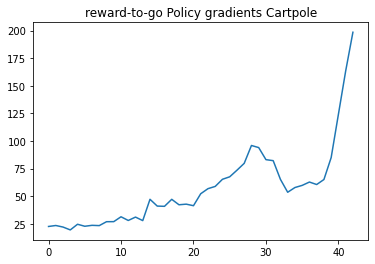

In [13]:
a = PolicyGradients(CartPole, "CartPole-v0", 32)

rewards = []
for v in tqdm(range(500)):
    rewards.append(a.train_reward_to_go())
    if np.mean(rewards[-3:]) > 160:
        break

plt.plot(rewards)
plt.title("reward-to-go Policy gradients Cartpole")
plt.show()

  8%|▊         | 39/500 [00:27<05:30,  1.39it/s]


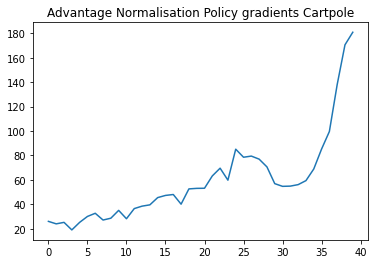

In [14]:
a = PolicyGradients(CartPole, "CartPole-v0", 32)

rewards = []
for v in tqdm(range(500)):
    rewards.append(a.train_advantage_normalisation())
    if np.mean(rewards[-3:]) > 160:
        break

plt.plot(rewards)
plt.title("Advantage Normalisation Policy gradients Cartpole")
plt.show()

# Question 2 Part B LunarLander

100%|██████████| 500/500 [08:24<00:00,  1.01s/it]


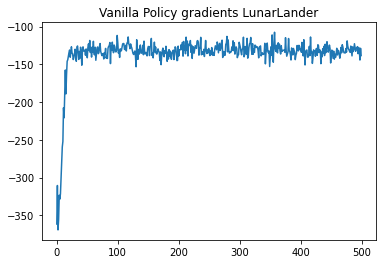

In [21]:
from tqdm import tqdm
import matplotlib.pyplot as plt

a = PolicyGradients(LunarLander, "LunarLander-v2", 32)

rewards = []
for v in tqdm(range(500)):
    rewards.append(a.train())
    if np.mean(rewards[-10:]) > -120:
        break

plt.plot(rewards)
plt.title("Vanilla Policy gradients LunarLander")
plt.show()

100%|██████████| 500/500 [08:52<00:00,  1.07s/it]


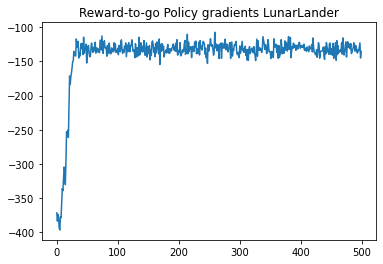

In [20]:
from tqdm import tqdm
import matplotlib.pyplot as plt

a = PolicyGradients(LunarLander, "LunarLander-v2", 32)

rewards = []
for v in tqdm(range(500)):
    rewards.append(a.train_reward_to_go())
    if np.mean(rewards[-10:]) > -120:
        break

plt.plot(rewards)
plt.title("Reward-to-go Policy gradients LunarLander")
plt.show()

100%|██████████| 500/500 [04:20<00:00,  1.92it/s]


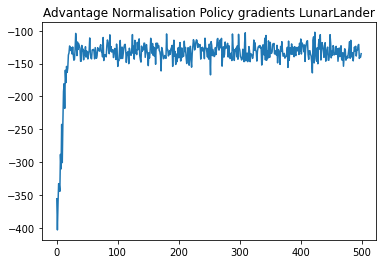

In [17]:
from tqdm import tqdm
import matplotlib.pyplot as plt

a = PolicyGradients(LunarLander, "LunarLander-v2", 16)

rewards = []
for v in tqdm(range(500)):
    rewards.append(a.train_advantage_normalisation())
    if np.mean(rewards[-10:]) > -120:
        break

plt.plot(rewards)
plt.title("Advantage Normalisation Policy gradients LunarLander")
plt.show()

# Question 2 Part C

  8%|▊         | 39/500 [00:39<07:46,  1.01s/it]


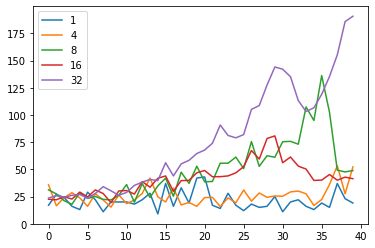

In [18]:
from tqdm import tqdm
lis = []
for i in [1, 4, 8, 16, 32]:

    a = PolicyGradients(CartPole, "CartPole-v0", i)

    rewards = []
    for v in tqdm(range(500)):
        rewards.append(a.train_advantage_normalisation())
        if np.mean(rewards[-3:]) > 160:
            break
    lis.append(rewards)

final = [[], [], [], [], []]
for a, b, c, d, e, in zip(*lis):
    final[0].append(a)
    final[1].append(b)
    final[2].append(c)
    final[3].append(d)
    final[4].append(e)
lis = final
plt.plot(lis[0], label="1")
plt.plot(lis[1], label="4")
plt.plot(lis[2], label="8")
plt.plot(lis[3], label="16")
plt.plot(lis[4], label="32")
plt.legend()
plt.show()

100%|██████████| 500/500 [08:41<00:00,  1.04s/it]


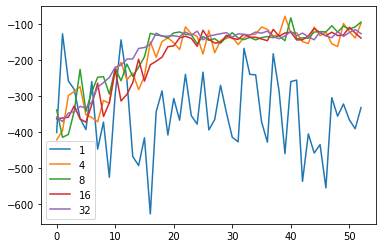

In [19]:
from tqdm import tqdm
lis = []
for i in [1, 4, 8, 16, 32]:

    a = PolicyGradients(LunarLander, "LunarLander-v2", i)

    rewards = []
    for v in tqdm(range(500)):
        rewards.append(a.train_advantage_normalisation())
        if np.mean(rewards[-10:]) > -120:
            break
    lis.append(rewards)

final = [[], [], [], [], []]
for a, b, c, d, e, in zip(*lis):
    final[0].append(a)
    final[1].append(b)
    final[2].append(c)
    final[3].append(d)
    final[4].append(e)
lis = final
plt.plot(lis[0], label="1")
plt.plot(lis[1], label="4")
plt.plot(lis[2], label="8")
plt.plot(lis[3], label="16")
plt.plot(lis[4], label="32")
plt.legend()
plt.show()